# Analiza wydolności układu drogowego miasta Słupsk

Celem projektu jest zbadanie jak zmienia się czas podróży w mieście w zależności od natężenia ruchu w Słupsku.

## Zarys projektu

1. Zamodelowanie dystrybucji miejsc zamieszkania i pracy w mieście (na podstawie https://bip.um.slupsk.pl/file/2774)
2. Klasteryzacja punktów
3. Wyznaczenie połączeń między klastrami na podstawie mapy drogowej Słupska i okolic
4. Uogólnienie połączeń między klastrami
    * zredukowanie liczby możliwych tras między sąsiadującymi klastrami do jednej
5. Wygenerowanie podróży między klastrami na podstawie 1.
6. Zbalansowanie ruchu (uproszczona wersja https://www.worldscientific.com/doi/10.1142/S0129183198000303)
7. Zbadanie zmiany średniego czasu podróży i innych rezultatów

In [22]:
import folium
import pathlib
import osmnx
import networkx
import numpy as np
from clusters import Cluster, ClusterCentreStrategy
from demo_utils import SimulationResults, simulate, create_df, create_line_plots, create_intercluster_travel_slowdown_graph, create_route_folium_map
from pathing import get_paths_between_clusters, create_cluster_graph
from population import PopulationGeneratorConfig, generate_data_points
from traffic import IncrementalBatchRouteAssigner, Route, Time
from travel import TravelGenerator
from utils import visualize_clusters, visualize_points, visualize_paths, visualize_weighted_paths, rescale
from tqdm import tqdm

In [12]:
RESOLUTION = 8
POPULATION_MULTIPLIERS = list(np.linspace(.5, 10., 20))
config = PopulationGeneratorConfig.from_json_file(pathlib.Path("configs/slupsk_2004.json"))
base_population = sum(epi.population_count for epi in config.epicentres)


cluster_centre_strategy = ClusterCentreStrategy.HEXAGON_CENTER
places = [
    'Słupsk, Polska',
    'gmina Słupsk, Polska',
    'gmina Kobylnica, Polska',
]
custom_filter = '["highway"~"motorway|primary|secondary|tertiary"]'
graph = osmnx.graph.graph_from_place(places, network_type="drive", custom_filter=custom_filter)
graph = osmnx.speed.add_edge_travel_times(osmnx.add_edge_speeds(graph))

## Przykładowy rozkład ludności 
Liczba punktów została sztucznie zaniżona dla czytelności mapy

In [13]:
config.multiply_population(.03)
pts_by_epi = {epi.label: generate_data_points(epi) for epi in config.epicentres}
colors = ["blue", "red", "green"]
pts_by_color = list(zip(colors, pts_by_epi.values()))

m = folium.Map(location=[54.46270136314862, 17.019373399360482], zoom_start=13, tiles='cartodbpositron')

for color, points in pts_by_color:
    visualize_points(m, points, [color])
    
m

## Przykładowa klastryzacja z zaznaczonymi drogami między klastrami

In [21]:
points = [point for pts in pts_by_epi.values() for point in pts]
atlas = get_paths_between_clusters(graph, clusters)
paths = atlas.get_paths()
clusters = Cluster.consolidate_clusters(Cluster.clusterize_points(points, RESOLUTION, cluster_centre_strategy),
                                        graph, RESOLUTION)
m = folium.Map(location=[54.46270136314862, 17.019373399360482], zoom_start=13, tiles='cartodbpositron')
visualize_clusters(m, clusters, ["green"])
visualize_paths(m, graph, paths)
m

## Wizualizacja połączeń między klastrami

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 12/20 [56:24<37:36, 282.04s/it]


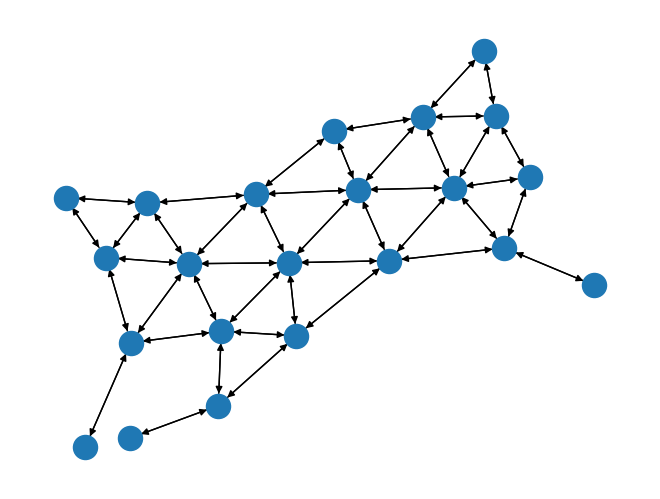

In [24]:
cluster_graph = create_cluster_graph(graph, clusters, RESOLUTION)
pos = networkx.spring_layout(cluster_graph, seed=200)
networkx.draw(cluster_graph, pos)

## Generowanie rezultatów dla różnych mnożników liczby ludności

In [3]:
results = [simulate(multiplier, RESOLUTION, cluster_centre_strategy, graph) for multiplier in tqdm(POPULATION_MULTIPLIERS)]

  0%|                                                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 2/4 [01:45<01:45, 52.53s/it]


 25%|█████████████████████████████████████████████████████▊                                                                                                                                                                 | 1/4 [01:25<04:17, 85.76s/it]


KeyboardInterrupt: 

In [25]:
import pickle

In [36]:
results_path = pathlib.Path(f"results")

# for result in results:
#     pth = results_path / f"{result.population_count}_data.pkl"
#     pth.parent.mkdir(exist_ok=True)
#     with open(pth, "wb") as f:
#         pickle.dump(result, f)
        

results = []
for file in results_path.glob("*_data.pkl"):
    with open(file, "rb") as f:
        results.append(pickle.load(f))

## Zmiana średniego czasu dojazdu w zależności od populacji (tj. ilości podróżujących)

<Axes: xlabel='population', ylabel='log_mean_travel_time'>

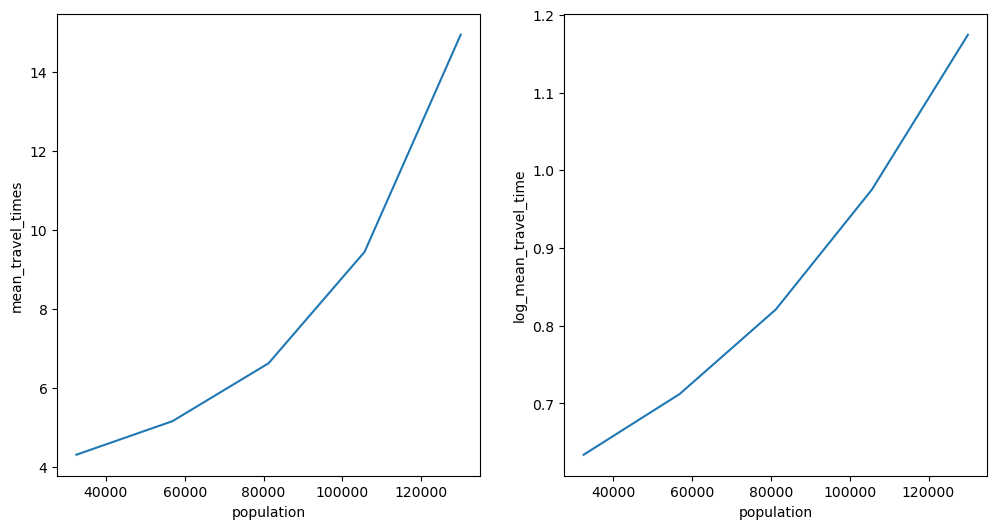

In [27]:
create_line_plots(create_df(results))

## Analiza opóźnień

In [28]:
import ipywidgets as widgets


results_by_population = {result.population_count:result for result in results}

w = widgets.SelectionSlider(
    options=list(results_by_population.keys()),
    value=list(results_by_population.keys())[0],
    description='Population count: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

def show_graph(pop_count):
    result = results_by_population[pop_count]
    display(create_intercluster_travel_slowdown_graph(result.cluster_graph, result.clusters))
    display(create_route_folium_map(result.cluster_graph, result.clusters, graph))

out = widgets.interactive_output(show_graph, {'pop_count': w})

widgets.VBox([w, out])

## Wyniki, wnioski i potencjalne usprawnienia

* pomimo daleko idących uproszczeń, udało się zasymulować spowolnienie ruchu wraz ze zwiększającą się liczbą podróży
* wg modelu sieć drogowa Słupska (ograniczając się do głównych ulic) może przyjąć nawet 150000 podróżnych z akceptowalnymi opoźnieniami
* potrzebnym usprawnieniem jest ulepszenie algorytmu balansującego ruch, ponieważ zdarzają się spore różnice między podróżującymi na między tymi samymi punktami